# CE-40959: Deep Learning

# HW3. Part 3. CNN on CIFAR (20 + 10 points)

### Deadline:   16 Farvardin

In this problem, we will train a CNN on CIFAR-10 database. Next, we will go through the network and visualize its layers to see what is happening there. Then, we use the trained model in a Transfer Learning approach to classifying the CIFAR-100 database.

Let's start with loading data. First load the data by runing the code below:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# !cp "/content/drive/My Drive/HW 3.3 CNN on CIFAR/load_data.py" .
from load_data import load_cifar10 #this function provided in the attached file loads the data of CIFAR10 database

def load_cifar10_data():
    dataset_dir = 'data/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_cifar10(dataset_dir)
    X_train, X_val = X_train[:45000], X_train[45000:]
    y_train, y_val = y_train[:45000], y_train[45000:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
X_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


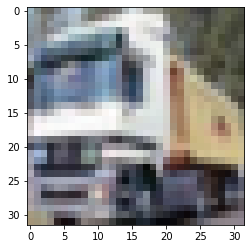

In [3]:
import matplotlib.pyplot as plt
plt.imshow(X_train[1].astype(int))#represnting a sample data from CIFAR-10
plt.show()

By successfully runing the above code, you have loaded the data and also you can see a sample data from CIFAR-10.

The below code will convert the labels to one-hot codes which will be later used for the classification.

In [4]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels
encoder = OneHotEncoder(sparse=False)

encoder.fit(y_train)#this line will fit 'encoder' to encode the labels

y_train_onehot = encoder.transform(y_train)# encoding train labels (one-hot coding)
y_val_onehot   = encoder.transform(y_val)  # encoding train labels (one-hot coding)
y_test_onehot  = encoder.transform(y_test) # encoding test  labels (one-hot coding)

The function below is for converting data to several batches which we will use in training.

In [5]:
def make_batches(x, y, batch_size):
    n = len(y)
    steps = n // batch_size
    if n % batch_size != 0:
        steps += 1
    x_batches = np.array_split(x, steps)
    y_batches = np.array_split(y, steps)
    return x_batches, y_batches

## Part1: Trainig a CNN (15 pts.)

In this part, we are going to train a Convolutional Neural Network (CNN) with the below structure:

1. 16 * conv(5,5), activation function =ReLU
2. 16 * conv(5,5), activation function =ReLU
3. Max-pooling(3,3), stride=(2,2)
4. 32 * conv(5,5), activation function =ReLU
5. 32 * conv(5,5), activation function =ReLU
6. Max-pooling(3,3), stride=(2,2)
7. 64 * conv(5,5), activation function =ReLU
8. FC(128), activation function =ReLU
9. FC(128), activation function =ReLU
10. FC(10), activation function =softmax

Let's go to implement the model in the below box. Note that using **tf.layers** is **NOT ALLOWED** in this homework.

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.set_random_seed(42)

tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 3]) # placeholder for input data
y = tf.placeholder(tf.float32, [None, 10])# placeholder for labels (one-hot encoded)

###################################################################
#########  TODO: Your code for implementing the network ###########
###################################################################

# Define the needed Variables here:
# e.g., W_conv1 has the shape of shape=[5, 5, 3, 16] and B_conv1 has the shape of shape=[16]
W_conv1 = tf.get_variable(name='W_conv1', shape=[5, 5, 3, 16], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_conv1 = tf.get_variable(name='B_conv1', shape=[16], initializer=tf.zeros_initializer)
W_conv2 = tf.get_variable(name='W_conv2', shape=[5, 5, 16, 16], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_conv2 = tf.get_variable(name='B_conv2', shape=[16], initializer=tf.zeros_initializer)
W_conv3 = tf.get_variable(name='W_conv3', shape=[5, 5, 16, 32], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_conv3 = tf.get_variable(name='B_conv3', shape=[32], initializer=tf.zeros_initializer)
W_conv4 = tf.get_variable(name='W_conv4', shape=[5, 5, 32, 32], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_conv4 = tf.get_variable(name='B_conv4', shape=[32], initializer=tf.zeros_initializer)
W_conv5 = tf.get_variable(name='W_conv5', shape=[5, 5, 32, 64], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_conv5 = tf.get_variable(name='B_conv5', shape=[64], initializer=tf.zeros_initializer)

W_fc1 = tf.get_variable(name='W_fc1', shape=[4096, 128], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_fc1 = tf.get_variable(name='B_fc1', shape=[128], initializer=tf.zeros_initializer)

W_fc2 = tf.get_variable(name='W_fc2', shape=[128, 128], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_fc2 = tf.get_variable(name='B_fc2', shape=[128], initializer=tf.zeros_initializer)

W_fc3 = tf.get_variable(name='W_fc3', shape=[128, 10], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_fc3 = tf.get_variable(name='B_fc3', shape=[10], initializer=tf.zeros_initializer)


# Define the layers here:
conv1 = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + B_conv1
conv1_relu = tf.nn.relu(conv1)
conv2 = tf.nn.conv2d(conv1_relu, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + B_conv2
conv2_relu = tf.nn.relu(conv2)
pooling1 = tf.nn.max_pool(conv2_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

conv3 = tf.nn.conv2d(pooling1, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + B_conv3
conv3_relu = tf.nn.relu(conv3)
conv4 = tf.nn.conv2d(conv3_relu, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + B_conv4
conv4_relu = tf.nn.relu(conv4)
pooling2 = tf.nn.max_pool(conv4_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

conv5 = tf.nn.conv2d(pooling2, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + B_conv5
conv5_relu = tf.nn.relu(conv5)
conv5_relu = tf.reshape(conv5_relu, [tf.shape(conv5_relu)[0], conv5_relu.shape[1]*conv5_relu.shape[2]*conv5_relu.shape[3]])

dense1 = tf.matmul(conv5_relu, W_fc1) + B_fc1
dense1_relu = tf.nn.relu(dense1)

dense2 = tf.matmul(dense1_relu, W_fc2) + B_fc2
dense2_relu = tf.nn.relu(dense2)

logits = tf.matmul(dense2_relu, W_fc3) + B_fc3
y_hat = tf.nn.softmax(logits)




# continue the same for other layers:
    
    
    
# Don't forget that:
# - you need to define variables with needed size and suitable initialization,
# - you need to use tf.nn.conv2d to implement convolution,
# - you need to use tf.nn.max_pool to implement max_pooling,

# Help: your network output is something like: y_hat = tf.nn.softmax(logits) where logits are values of last layer 
#       before softmax activation function.
#############################################################

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Now you need to define an optimizer. You are free to use any optimizer. You can change optimizer or learning rate if you want :)

In [7]:
############ Cross entropy loss ############################
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
# Note: logits in the above line is the last layer values (a 10-neuron layer) before the softmax activation function. 
#       In other words, you may have written y_hat = tf.nn.softmax(logits) in the above box in which y_hat is the output
#       of the network.

############ Adam optimizer ################################
lr = 1e-3 # learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
regularization_factor = 0.001
regularization = tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)+ tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2)
trainer = optimizer.minimize(cross_entropy + regularization * regularization_factor)
############################################################
#            TODO: Implement Accuracy                      #
############################################################
correct_preds = tf.argmax(y, axis=1)
model_preds = tf.argmax(y_hat, axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(model_preds, correct_preds), tf.float32))
# Note: The defined accuray does not play any role in the optimization process. However, it is a mtric which we can 
#       use as a log for mintoring training process with more metrics rather than a single loss function.
############################################################

You can go for the rest of the job, handle the Session and go for training. 
You can use tensorboard or the code provided in the next box to plot for loss and accuracy of training and validation data.
You are expected to achieve at least 60% accuracy on the test data after the training process. Good Luck! ;)

In [8]:
########## Training ##########
batch_size = 64 # You are free to change it
x_train_batches, y_train_batches = make_batches(X_train, y_train_onehot, batch_size)
epochs = 10  # You are free to change it
N_Batches = len(x_train_batches)

train_acc  = np.zeros(epochs)
train_loss = np.zeros(epochs)
val_acc  = np.zeros(epochs)
val_loss = np.zeros(epochs)

with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess:
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

    for epoch in range(epochs):
        print()
        print("*" * 10, "Epoch %3i"%epoch, "*" * 10)

        batch_acc = np.zeros(N_Batches)
        batch_loss = np.zeros(N_Batches)
        for n in range(N_Batches):
            _, batch_acc[n], batch_loss[n] = sess.run([trainer, accuracy, cross_entropy],
                                                      {x: x_train_batches[n], y: y_train_batches[n]})
            # print("Batch %3d/%d: Acc:%0.4f , Loss:%0.4f"%(n, N_Batches, batch_acc[n], batch_loss[n]))

        train_acc[epoch] = np.mean(batch_acc)
        train_loss[epoch] = np.mean(batch_loss)
        print("Train:\t\tAccuracy= %0.4f \tLoss= %0.4f"%(train_acc[epoch], train_loss[epoch]))

        ########## Validation ##########
        val_acc[epoch], val_loss[epoch] = sess.run([accuracy, cross_entropy],
                                                   {x: X_val, y: y_val_onehot})
        print("Validation:\tAccuracy= %0.4f \tLoss= %0.4f"%(val_acc[epoch], val_loss[epoch]))
        
    test_acc, test_loss = 0, 0
    test_acc, test_loss = sess.run([accuracy, cross_entropy], 
                                   {x: X_test, y: y_test_onehot})

    w_conv1_CIFAR10 = sess.run(W_conv1)
    b_conv1_CIFAR10 = sess.run(B_conv1)
    w_conv2_CIFAR10 = sess.run(W_conv2)
    b_conv2_CIFAR10 = sess.run(B_conv2)
    w_conv3_CIFAR10 = sess.run(W_conv3)
    b_conv3_CIFAR10 = sess.run(B_conv3)
    w_conv4_CIFAR10 = sess.run(W_conv4)
    b_conv4_CIFAR10 = sess.run(B_conv4)
    w_conv5_CIFAR10 = sess.run(W_conv5)
    b_conv5_CIFAR10 = sess.run(B_conv5)
    w_fc1_CIFAR10 = sess.run(W_fc1)
    b_fc1_CIFAR10 = sess.run(B_fc1)############################################################
#            TODO: Implement Test Phase                    #
############################################################

print("Test:\tAccuracy= %0.4f \tLoss= %0.4f"%(test_acc, test_loss))
############################################################


********** Epoch   0 **********
Train:		Accuracy= 0.3907 	Loss= 1.6906
Validation:	Accuracy= 0.4676 	Loss= 1.4975

********** Epoch   1 **********
Train:		Accuracy= 0.5220 	Loss= 1.3403
Validation:	Accuracy= 0.5522 	Loss= 1.2713

********** Epoch   2 **********
Train:		Accuracy= 0.5854 	Loss= 1.1764
Validation:	Accuracy= 0.5760 	Loss= 1.2034

********** Epoch   3 **********
Train:		Accuracy= 0.6275 	Loss= 1.0597
Validation:	Accuracy= 0.6020 	Loss= 1.1738

********** Epoch   4 **********
Train:		Accuracy= 0.6540 	Loss= 0.9774
Validation:	Accuracy= 0.6168 	Loss= 1.1662

********** Epoch   5 **********
Train:		Accuracy= 0.6738 	Loss= 0.9230
Validation:	Accuracy= 0.6254 	Loss= 1.1304

********** Epoch   6 **********
Train:		Accuracy= 0.6919 	Loss= 0.8629
Validation:	Accuracy= 0.6086 	Loss= 1.2867

********** Epoch   7 **********
Train:		Accuracy= 0.7128 	Loss= 0.8158
Validation:	Accuracy= 0.5890 	Loss= 1.3563

********** Epoch   8 **********
Train:		Accuracy= 0.7295 	Loss= 0.7699
Validati

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[10000,16,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-6-39f00ec25501>:38) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Mean_1/_21]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[10000,16,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-6-39f00ec25501>:38) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-6-39f00ec25501>:7)

Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-6-39f00ec25501>:7)

Original stack trace for 'Conv2D':
  File "/usr/lib/python3.8/runpy.py", line 193, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/ben/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ben/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ben/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/ben/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ben/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ben/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
    self.do_execute(
  File "/home/ben/.local/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ben/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ben/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ben/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2857, in run_cell
    result = self._run_cell(
  File "/home/ben/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/ben/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ben/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3062, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/ben/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ben/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-39f00ec25501>", line 38, in <module>
    conv1 = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + B_conv1
  File "/home/ben/.local/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py", line 2006, in conv2d
    return gen_nn_ops.conv2d(input,  # pylint: disable=redefined-builtin
  File "/home/ben/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 965, in conv2d
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/ben/.local/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 742, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/ben/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3319, in _create_op_internal
    ret = Operation(
  File "/home/ben/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1791, in __init__
    self._traceback = tf_stack.extract_stack()


### Training Diagram

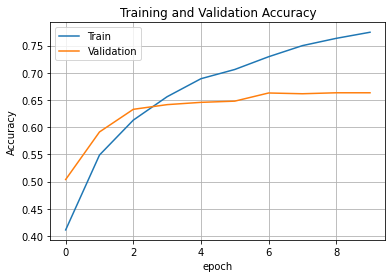

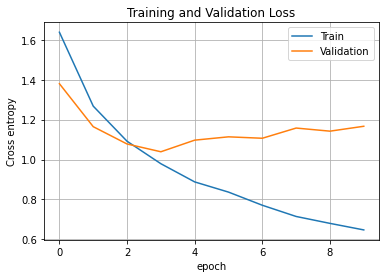

In [72]:
########## Plot metrics #########################
fig = plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), val_acc, label='Validation')
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

fig = plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), val_loss, label='Validation')
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Cross entropy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

## Part2: Visualizing the Network (5 pts.)

Now, we want to check the weights to see how the network realy works and what it does. Consider the wieghts of the first convolutional layer, find its weights values and print the values of 2 arbitrary filters:

In [73]:
##########################################################################
# TODO                                                                   #
# Note: To retrieve the values of the weight-variables from TensorFlow,  #
#       feed-dict is not necessary because                               #
#       nothing is calculated.                                           #
#       e.g., w = sess.run(weights)                                      #
##########################################################################

print('Filter 0: \n\n')
print(w_conv1_CIFAR10[:,:,0,0])
print(w_conv1_CIFAR10[:,:,1,0])
print(w_conv1_CIFAR10[:,:,2,0])
print()
print('Filter 11: \n\n')
print(w_conv1_CIFAR10[:,:,0,11])
print(w_conv1_CIFAR10[:,:,1,11])
print(w_conv1_CIFAR10[:,:,2,11])

##########################################################################

Filter 0: 


[[-2.0572891e-07 -8.6984029e-09 -9.6363728e-08 -3.3911533e-07
  -2.0703930e-13]
 [-7.9058779e-08 -5.9395827e-10 -7.5868609e-09 -2.8061461e-07
  -3.8544602e-13]
 [-1.5740860e-09 -1.8724195e-12 -3.0104014e-10 -7.2643530e-08
  -6.4570785e-14]
 [-3.0780524e-13 -4.1047739e-19 -4.2330934e-13 -2.0287148e-10
  -4.5645985e-13]
 [-2.1202922e-09 -3.8811017e-11 -1.1287604e-10 -2.2244009e-07
  -3.6725092e-10]]
[[-6.5760514e-07 -3.4992087e-08 -1.3632045e-07 -4.5250906e-07
  -1.2010004e-13]
 [-3.1813830e-08 -3.2440752e-09 -5.5328748e-08 -1.6563118e-06
  -3.9890031e-13]
 [-7.8470025e-10 -7.4227170e-12 -2.5249240e-09 -3.3211160e-07
  -3.8879256e-14]
 [-1.0399590e-14 -1.8995067e-23 -1.2904314e-13 -7.0710260e-10
  -1.8809084e-13]
 [-7.3935619e-10 -8.4300920e-11 -5.4172106e-10 -4.4335650e-07
  -3.2450742e-10]]
[[ 9.36504819e-07 -1.67571770e-07 -7.63749540e-07 -2.40504960e-06
  -1.32840275e-11]
 [-1.50579766e-07 -9.84968729e-09 -3.23486631e-07 -1.00829503e-07
  -2.45202070e-11]
 [-1.49601345e-

Now let's visualize the filters of the first conv layer. There are lots of ways to code for visualization. You are free to choose any way you want. However below is function which is provided for you to plot the weights.

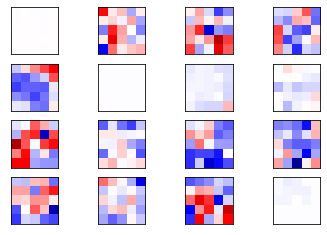

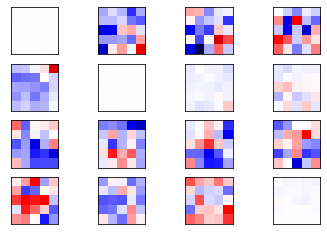

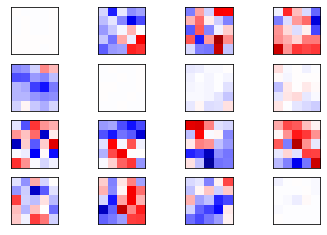

In [74]:
import math
def plot_conv_weights(w, input_channel=0):
    # The argument w is a 4-dim array.(e.g. weights_conv1 with the shape of [5,5,3,64])
    # The argument input_channel shows the specified channel of all filters.
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

    
##########################################################################
# TODO: call the function above or use your own way here                 #
##########################################################################
plot_conv_weights(w_conv1_CIFAR10, 0)
plot_conv_weights(w_conv1_CIFAR10, 1)
plot_conv_weights(w_conv1_CIFAR10, 2)

##########################################################################


## Part3: Transfer Learning (+10 pts. - optional)

In all the machine learning problems we need data to train our models. However, the volume of the data might not be sufficient for the considered model. In such cases, we may use a model which is trained on a similar dataset probably for a different objective. Then we transfer to the main problem and fine- tune or replace some parts of the network. 

In this exercise, we are going to implement the transfer learning concept on CNN. For this purpose, we use the network that you have trained on Part 1 of this homework (above) to classify three new classes (i.e. bee, elephant, and fox) on CIFAR-100 dataset. Let's first load the data:

In [ ]:
from load_data import load_cifar100 #this function provided in the attached file loads the data of CIFAR100 database

def load_cifar100_data():
    dataset_dir = '/content/drive/My Drive/HW 3.3 CNN on CIFAR/data/cifar-100-python'
    
    X_train, y_train, X_test, y_test = load_cifar100(dataset_dir)
    
    return X_train, y_train, X_test, y_test

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


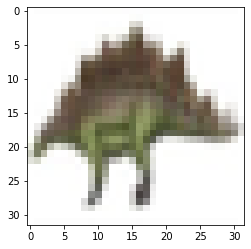

In [76]:
X_train, y_train, X_test, y_test = load_cifar100_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

import matplotlib.pyplot as plt
plt.imshow(X_train[1].astype(int))#represnting a sample data from CIFAR-100
plt.show()

By successfully runing the above code, you have loaded the data and also you can see a sample data from CIFAR-100. The below code will seprate the specified classes (i.e. bee(6), elephant(31), and fox(34)) for the new classification problem.

In [ ]:
selected_images_train = np.zeros([1,32,32,3])
selected_labels_train = np.zeros([1,1])
for i in range(50000):
    label = y_train[i]
    if label==6 or label==31 or label==34:
        selected_images_train = np.append(selected_images_train,np.reshape(X_train[i,:,:,:],[1,32,32,3]),axis=0)
        selected_labels_train = np.append(selected_labels_train,np.reshape(label,[1,1]),axis=0)
selected_images_train = selected_images_train[1:]# to remove the first defined np..zeros data
selected_labels_train = selected_labels_train[1:]# to remove the first defined np..zeros data


selected_images_test = np.zeros([1,32,32,3])
selected_labels_test = np.zeros([1,1])
for i in range(10000):
    label = y_test[i]
    if label==6 or label==31 or label==34:
        selected_images_test = np.append(selected_images_test,np.reshape(X_test[i,:,:,:],[1,32,32,3]),axis=0)
        selected_labels_test = np.append(selected_labels_test,np.reshape(label,[1,1]),axis=0)
selected_images_test = selected_images_test[1:]# to remove the first defined np..zeros data
selected_labels_test = selected_labels_test[1:]# to remove the first defined np..zeros data

In [78]:
images_train = selected_images_train[:int(selected_images_train.shape[0]*0.8),:,:,:]
labels_train = selected_labels_train[:int(selected_images_train.shape[0]*0.8),:]

images_validation = selected_images_train[int(selected_images_train.shape[0]*0.8):,:,:,:]
labels_validation = selected_labels_train[int(selected_images_train.shape[0]*0.8):,:]

images_test = selected_images_test
labels_test = selected_labels_test


print('images_train shape:', images_train.shape)
print('labels_train shape:', labels_train.shape)

print('images_validation shape:', images_validation.shape)
print('labels_validation shape:', labels_validation.shape)

print('images_test shape:', images_test.shape)
print('labels_test shape:', labels_test.shape)

images_train shape: (1200, 32, 32, 3)
labels_train shape: (1200, 1)
images_validation shape: (300, 32, 32, 3)
labels_validation shape: (300, 1)
images_test shape: (300, 32, 32, 3)
labels_test shape: (300, 1)


In [ ]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels
encoder = OneHotEncoder(sparse=False)

encoder.fit(selected_labels_train)#this line will fit 'encoder' to encode the labels

labels_train_onehot = encoder.transform(labels_train)# encoding train labels (one-hot coding)
labels_val_onehot   = encoder.transform(labels_validation)  # encoding train labels (one-hot coding)
labels_test_onehot  = encoder.transform(labels_test) # encoding test  labels (one-hot coding)

To implement the transfer learning, we need to use the previous model and transfer it to the new problem. For this end, you need to freeze the convolution layers and also the first fully connected layer which means that they should not be updated in the new training process. For the last two fully connected layers, we want to fine-tune the values. However, you should replace the last layer (output layer) with a 3-neuron layer to represent the score for each class.

There are several methods that you can implement the discussed process with TensorFlow. You are free to do any way you want.
The below code redefine the network and use the weights of the network trained on CIFAR-10. Then, the frozen weights can be defined as either constant or non-trainable variables. Besides, the fine-tuning weights are also defined as variables with their previous weights in the definition. Anyway, since there are other ways to implement this job, you can do it with your own method.

In [ ]:
############################################################
#            TODO: Implement Accuracy Part                 #
############################################################

# get the weights form previous network:
# e.g., w_conv1_CIFAR10 = sess.run(W_conv1)


tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 3]) # placeholder for input data
y_new = tf.placeholder(tf.float32, [None, 3])# placeholder for labels (one-hot encoded)

# Re-define the convolutional layers
conv1 = tf.nn.conv2d(x, w_conv1_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + b_conv1_CIFAR10
conv1_relu = tf.nn.relu(conv1)
conv2 = tf.nn.conv2d(conv1_relu, w_conv2_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + b_conv2_CIFAR10
conv2_relu = tf.nn.relu(conv2)

pooling1 = tf.nn.max_pool(conv2_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
conv3 = tf.nn.conv2d(pooling1, w_conv3_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + b_conv3_CIFAR10
conv3_relu = tf.nn.relu(conv3)
conv4 = tf.nn.conv2d(conv3_relu, w_conv4_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + b_conv4_CIFAR10
conv4_relu = tf.nn.relu(conv4)

pooling2 = tf.nn.max_pool(conv4_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
conv5 = tf.nn.conv2d(pooling2, w_conv5_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + b_conv5_CIFAR10
conv5_relu = tf.nn.relu(conv5)
conv5_relu = tf.reshape(conv5_relu, [tf.shape(conv5_relu)[0], conv5_relu.shape[1]*conv5_relu.shape[2]*conv5_relu.shape[3]])

fc1 = tf.matmul(conv5_relu, w_fc1_CIFAR10) + b_fc1_CIFAR10
fc1_relu = tf.nn.relu(fc1)

# Define weights for the second FC layer (fc1 is already defined in the previous model)
W_fc2_new = tf.get_variable(name='W_fc2', shape=[128, 128], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_fc2_new = tf.get_variable(name='B_fc2', shape=[128], initializer=tf.zeros_initializer)
# Define based on the first fully connected layer.
fc2_new = tf.matmul(fc1_relu, W_fc2_new) + B_fc2_new
fc2_relu_new = tf.nn.relu(fc2_new)

W_fc3_new = tf.get_variable(name='W_fc3', shape=[128, 3], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
B_fc3_new = tf.get_variable(name='B_fc3', shape=[3], initializer=tf.zeros_initializer)
# Define based on the second fully connected layer (fc2_new).
logit = tf.matmul(fc2_relu_new, W_fc3_new) + B_fc3_new

y_hat = tf.nn.softmax(logit)


#############################################################

########## Cross entropy loss ##########
new_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=y_new))

############################################################
#            TODO: Implement the optimizer so that only    #
#                  variales defined above are updated.     #
############################################################
lr = 1e-4
new_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
new_trainer = new_optimizer.minimize(new_cross_entropy, var_list=[W_fc2_new, W_fc3_new, B_fc2_new, B_fc3_new])
############################################################

############################################################
#            TODO: Implement Accuracy                      #
############################################################
correct_preds = tf.argmax(y_new, axis=1)
model_preds = tf.argmax(y_hat, axis=1)
new_accuracy = tf.reduce_mean(tf.cast(tf.equal(model_preds, correct_preds), tf.float32))
############################################################

Now, go for the rest of the job and start training:

In [95]:
########## Training ##########
batch_size = 64 # You are free to change it
x_train_batches, y_train_batches = make_batches(images_train, labels_train_onehot, batch_size)
epochs = 50  # You are free to change it
N_Batches = len(x_train_batches)

train_acc  = np.zeros(epochs)
train_loss = np.zeros(epochs)
val_acc  = np.zeros(epochs)
val_loss = np.zeros(epochs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        print()
        print("*" * 10, "Epoch %3i"%epoch, "*" * 10)

        batch_acc = np.zeros(N_Batches)
        batch_loss = np.zeros(N_Batches)
        for n in range(N_Batches):
            _, batch_acc[n], batch_loss[n] = sess.run([new_trainer, new_accuracy, new_cross_entropy],
                                                      {x: x_train_batches[n], y_new: y_train_batches[n]})
            #print("Batch %3d/%d: Acc:%0.4f , Loss:%0.4f"%(n, N_Batches, batch_acc[n], batch_loss[n]))

        train_acc[epoch] = np.mean(batch_acc)
        train_loss[epoch] = np.mean(batch_loss)
        print("Train:\t\tAccuracy= %0.4f \tLoss= %0.4f"%(train_acc[epoch], train_loss[epoch]))

        ########## Validation ##########
        val_acc[epoch], val_loss[epoch] = sess.run([new_accuracy, new_cross_entropy],
                                                   {x: images_validation, y_new: labels_val_onehot})
        print("Validation:\tAccuracy= %0.4f \tLoss= %0.4f"%(val_acc[epoch], val_loss[epoch]))
        
############################################################
#            TODO: Implement Test Phase                    #
############################################################
...
print("Test:\tAccuracy= %0.4f \tLoss= %0.4f"%(test_acc, test_loss))
############################################################


********** Epoch   0 **********
Train:		Accuracy= 0.3134 	Loss= 2.0680
Validation:	Accuracy= 0.2700 	Loss= 1.9548

********** Epoch   1 **********
Train:		Accuracy= 0.3418 	Loss= 1.7289
Validation:	Accuracy= 0.3300 	Loss= 1.6902

********** Epoch   2 **********
Train:		Accuracy= 0.3843 	Loss= 1.5152
Validation:	Accuracy= 0.3800 	Loss= 1.5178

********** Epoch   3 **********
Train:		Accuracy= 0.4051 	Loss= 1.3701
Validation:	Accuracy= 0.3800 	Loss= 1.4047

********** Epoch   4 **********
Train:		Accuracy= 0.4368 	Loss= 1.2673
Validation:	Accuracy= 0.4000 	Loss= 1.3225

********** Epoch   5 **********
Train:		Accuracy= 0.4560 	Loss= 1.1907
Validation:	Accuracy= 0.4033 	Loss= 1.2591

********** Epoch   6 **********
Train:		Accuracy= 0.4719 	Loss= 1.1301
Validation:	Accuracy= 0.4133 	Loss= 1.2076

********** Epoch   7 **********
Train:		Accuracy= 0.4985 	Loss= 1.0813
Validation:	Accuracy= 0.4200 	Loss= 1.1660

********** Epoch   8 **********
Train:		Accuracy= 0.5101 	Loss= 1.0417
Validati

You can use tensorboard or the code provided in the next box to plot for loss and accuracy of training and validation data. You are expected to achieve at least 80% accuracy on the test data after training. Good Luck! ;)

### Training Diagram

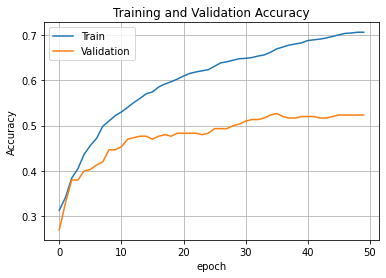

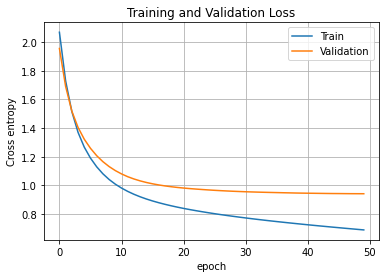

In [96]:
########## Plot metrics #########################
fig = plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), val_acc, label='Validation')
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

fig = plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), val_loss, label='Validation')
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Cross entropy")
plt.grid(True)
plt.legend(loc=0)
plt.show()